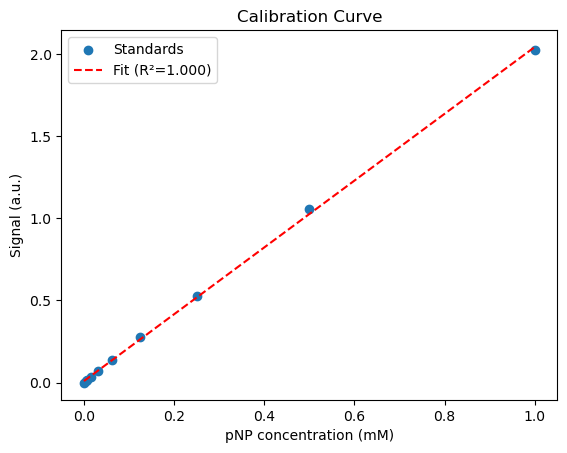

In [7]:
# Microtiter Plate Enzymatic Reaction Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

# -------------------------
# Step 1: Load raw plate data
# -------------------------

file_path = Path("20A_data.csv")
df = pd.read_csv(file_path)  # wells A1...H12 as columns, no time column

# Generate time vector (30 s per measurement)
n_points = df.shape[0]
time = np.arange(0, n_points * 30, 30)  # seconds
wells = df.copy()

# -------------------------
# Step 2: Define experimental layout
# -------------------------

layout = {
    "A1": "blank", "B1": "blank", "C1": "blank", "D1": "blank", "E1": "blank",
    "F3": "std_1mM", "F4": "std_0.5mM",
    "F5": "std_0.25mM", "F6": "std_0.125mM", "F7": "std_0.0625mM",
    "F8": "std_0.031mM", "F9": "std_0.016mM", "F10": "std_0.0078mM",
    "F11": "std_0.0039mM", "F12": "std_0mM",
    **{f"G{i}": f"std_{conc}mM" for i, conc in enumerate(
        [1,0.5,0.25,0.125,0.0625,0.031,0.016,0.0078,0.0039,0], start=3)},
    **{f"H{i}": f"std_{conc}mM" for i, conc in enumerate(
        [1,0.5,0.25,0.125,0.0625,0.031,0.016,0.0078,0.0039,0], start=3)},
    "A2": "reaction1", "A3": "reaction1", "A4": "reaction1",
    "B2": "reaction2", "B3": "reaction2", "B4": "reaction2",
    "C2": "reaction3", "C3": "reaction3", "C4": "reaction3",
    "D2": "reaction4", "D3": "reaction4", "D4": "reaction4",
    "E2": "reaction5", "E3": "reaction5", "E4": "reaction5"
}

# -------------------------
# Step 3: Group wells by type
# -------------------------

groups = defaultdict(list)
for well, label in layout.items():
    groups[label].append(well)

# -------------------------
# Step 4: Blank subtraction
# -------------------------

blank_mean = wells[groups["blank"]].mean(axis=1)
wells_corrected = wells.subtract(blank_mean, axis=0)

# -------------------------
# Step 5: Build calibration curve (using only first row of each std well)
# -------------------------

std_labels = [g for g in groups if g.startswith("std_")]
std_conc = []
std_values = []

for label in std_labels:
    conc = float(label.split("_")[1].replace("mM", ""))
    first_points = wells_corrected[groups[label]].iloc[0]  # row 0 only
    mean_signal = first_points.mean()
    std_conc.append(conc)
    std_values.append(mean_signal)

std_conc = np.array(std_conc)
std_values = np.array(std_values)

# Linear regression with np.polyfit
sl, int = np.polyfit(std_conc, std_values, 1)

# Calculate R^2
y_pred = sl * std_conc + int
ss_res = np.sum((std_values - y_pred)**2)
ss_tot = np.sum((std_values - np.mean(std_values))**2)
r2 = 1 - (ss_res / ss_tot)

plt.figure()
plt.scatter(std_conc, std_values, label="Standards")
x_fit = np.linspace(0, max(std_conc), 100)
plt.plot(x_fit, sl * x_fit + int, "r--", label=f"Fit (R²={r2:.3f})")
plt.xlabel("pNP concentration (mM)")
plt.ylabel("Signal (a.u.)")
plt.legend()
plt.title("Calibration Curve")
plt.show()

